In [ ]:
import pandas as pd
import itertools
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet_ic')

# Lab 5

For the fifth practical of the subject, the goal is to get in touch with some similarity measures and synsets. We are asked to get the most frequent WordNet synset, their corresponding least common subsumer (LCS) and their similarity value for a set of pairs (lemma, category) given. To calculate the similarity 4 are proposed:

- Path Similarity
- Leacock-Chodorow Similarity
- Wu-Palmer Similarity
- Lin Similarity

In [ ]:
pairs = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'), 
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

# Synsets

First, it is key to note that, since `wordnet` **POS constants** are: 
ADJ, ADJ_SAT, ADV, NOUN, VERB = "a", "s", "r", "n", "v",
we can only consider pairs where the lemma belongs to one of these categories. Thus, we cannot take into account the pairs where the category is 'DT', 'PR' or 'CC'. 

That is, we will only consider the pairs: `('man','NN'), ('swim','VB'), ('girl','NN'), ('boy', 'NN'), ('woman', 'NN'), ('walk', 'VB')` and ignore the pairs: `('the','DT'), ('with', 'PR'), ('and', 'CC'), ('a', 'DT'), ('whilst', 'PR'),('the', 'DT')`.

We filter them with the following code, keeping the desired pairs with their corresponding synsets inside the `synsets` list:

In [ ]:
tags = {'NN': wn.NOUN,
        'VB': wn.VERB,
        'JJ': wn.ADJ, 
        'RB': wn.ADV}

synsets = []
for pair in pairs:
  tag = tags.get(pair[1])
  if tag:
     synsets.append((pair, (wn.synsets(pair[0], tag))))

## Most frequent WordNet synsets

Wordnet orders synsets by the estimated frequency of use. Hence, the first synsets will already be the most frequent. We return the most frequent synset with the lemmas and their appearance frequencies in some unknown corpus. There is literally no source file in the documentation which specifies which corpus was used to create this data. Even though it says in *Speech and Language Processing* that it comes from the SemCor corpus. This corpus is a subset of the Brown corpus, both of which are outdated. A better approach would be to update this corpus to meet our needs from a given corpus. 

In [ ]:
for synset in synsets:
  print('For pair:', synset[0], '\n\tMost Frequent Synset is:', synset[1][0])
  print('\tIt has the following (lemma, frequency):', [(lemma.name(), lemma.count()) for lemma in synset[1][0].lemmas()])
  print()

For pair: ('man', 'NN') 
	Most Frequent Synset is: Synset('man.n.01')
	It has the following (lemma, frequency): [('man', 749), ('adult_male', 0)]

For pair: ('swim', 'VB') 
	Most Frequent Synset is: Synset('swim.v.01')
	It has the following (lemma, frequency): [('swim', 12)]

For pair: ('girl', 'NN') 
	Most Frequent Synset is: Synset('girl.n.01')
	It has the following (lemma, frequency): [('girl', 80), ('miss', 3), ('missy', 0), ('young_lady', 1), ('young_woman', 4), ('fille', 0)]

For pair: ('boy', 'NN') 
	Most Frequent Synset is: Synset('male_child.n.01')
	It has the following (lemma, frequency): [('male_child', 0), ('boy', 144)]

For pair: ('woman', 'NN') 
	Most Frequent Synset is: Synset('woman.n.01')
	It has the following (lemma, frequency): [('woman', 143), ('adult_female', 0)]

For pair: ('walk', 'VB') 
	Most Frequent Synset is: Synset('walk.v.01')
	It has the following (lemma, frequency): [('walk', 184)]



# Least common subsumer (LCS)

The LCS of two concepts is the most specific concept, which is an ancestor of both these concepts. Wordnet’s `lowest_common_hypernyms` method is used to locate the lowest single hypernym that is shared by two given words. This method is an implementation of Ted Pedersen's LCS method from the Perl Wordnet module. Take into consideration that only words with the same POS tag can be "compared".



In [ ]:
data_lcs = []
for syn1, syn2 in itertools.combinations(synsets, 2):
  if syn1[0][1] == syn2[0][1]:
    lcs = syn1[1][0].lowest_common_hypernyms(syn2[1][0])
    # just to make sure they give the same both ways
    lcs1 = syn2[1][0].lowest_common_hypernyms(syn1[1][0])
    data_lcs.append([syn1[0], syn2[0], lcs, lcs1])

In [ ]:
pd.DataFrame(data_lcs, columns=['Pair 1', 'Pair 2', 'LCS (P1.LCS(P2))', 'LCS (P2.LCS(P1))'])

,Pair 1,Pair 2,LCS (P1.LCS(P2)),LCS (P2.LCS(P1))
0,"(man, NN)","(girl, NN)",[Synset('adult.n.01')],[Synset('adult.n.01')]
1,"(man, NN)","(boy, NN)",[Synset('male.n.02')],[Synset('male.n.02')]
2,"(man, NN)","(woman, NN)",[Synset('adult.n.01')],[Synset('adult.n.01')]
3,"(swim, VB)","(walk, VB)",[Synset('travel.v.01')],[Synset('travel.v.01')]
4,"(girl, NN)","(boy, NN)",[Synset('person.n.01')],[Synset('person.n.01')]
5,"(girl, NN)","(woman, NN)",[Synset('woman.n.01')],[Synset('woman.n.01')]
6,"(boy, NN)","(woman, NN)",[Synset('person.n.01')],[Synset('person.n.01')]


# Similarities

We compare all synsets with each other and measure the 4 different similarities asked. For each pair, we check the similarity of the first element to the second and the other way around.

We normalize the Leacock-Chodorow Similarity by dividing the given similarity of synset 1 with synset 2 by the maximum value it could achieve, which is the Leacock-Chodorow similarity of the synset with itself.

In [ ]:
brown_ic = wordnet_ic.ic('ic-brown.dat')
data_sim = []

for syn1, syn2 in itertools.product(synsets, synsets):
  if syn1[0][1] == syn2[0][1]:
    pat = syn1[1][0].path_similarity(syn2[1][0])
    lch = syn1[1][0].lch_similarity(syn2[1][0]) / syn1[1][0].lch_similarity(syn1[1][0]) 
    wup = syn1[1][0].wup_similarity(syn2[1][0]) 
    lin = syn1[1][0].lin_similarity(syn2[1][0], brown_ic)
    data_sim.append([syn1[0], syn2[0], syn1[1][0], syn2[1][0], pat, lch, wup, lin])

In [ ]:
df_sim = pd.DataFrame(data_sim, columns=['Pair 1', 'Pair 2', 'Syn1', 'Syn2', 'Path Similarity', 'Leacock-Chodorow Similarity', 'Wu-Palmer Similarity', 'Lin Similarity'])
df_sim

,Pair 1,Pair 2,Syn1,Syn2,Path Similarity,Leacock-Chodorow Similarity,Wu-Palmer Similarity,Lin Similarity
0,"(man, NN)","(man, NN)",Synset('man.n.01'),Synset('man.n.01'),1.000000,1.000000,1.000000,1.000000
1,"(man, NN)","(girl, NN)",Synset('man.n.01'),Synset('girl.n.01'),0.250000,0.618897,0.631579,0.713511
2,"(man, NN)","(boy, NN)",Synset('man.n.01'),Synset('male_child.n.01'),0.333333,0.697983,0.666667,0.729472
3,"(man, NN)","(woman, NN)",Synset('man.n.01'),Synset('woman.n.01'),0.333333,0.697983,0.666667,0.787084
4,"(swim, VB)","(swim, VB)",Synset('swim.v.01'),Synset('swim.v.01'),1.000000,1.000000,1.000000,1.000000
5,"(swim, VB)","(walk, VB)",Synset('swim.v.01'),Synset('walk.v.01'),0.333333,0.662805,0.333333,0.491005
6,"(girl, NN)","(man, NN)",Synset('girl.n.01'),Synset('man.n.01'),0.250000,0.618897,0.631579,0.713511
7,"(girl, NN)","(girl, NN)",Synset('girl.n.01'),Synset('girl.n.01'),1.000000,1.000000,1.000000,1.000000
8,"(girl, NN)","(boy, NN)",Synset('girl.n.01'),Synset('male_child.n.01'),0.166667,0.507432,0.631579,0.292728
9,"(girl, NN)","(woman, NN)",Synset('girl.n.01'),Synset('woman.n.01'),0.500000,0.809449,0.631579,0.906780


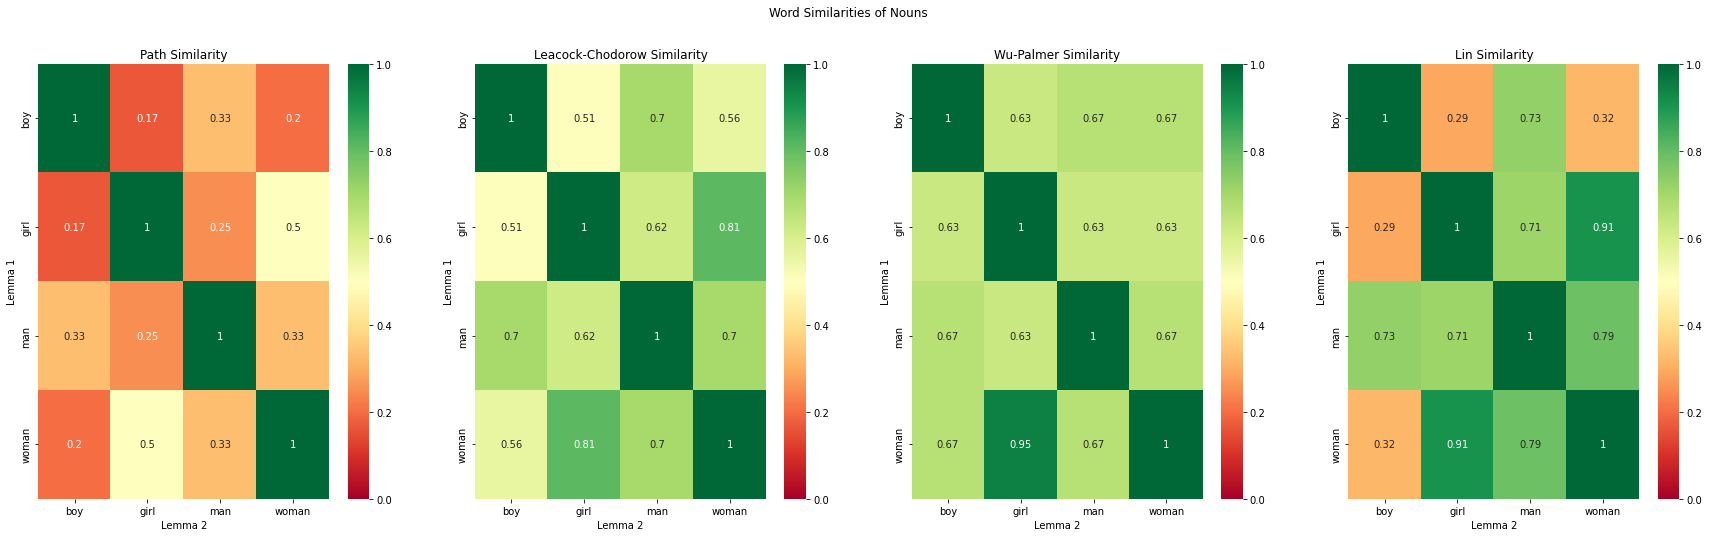

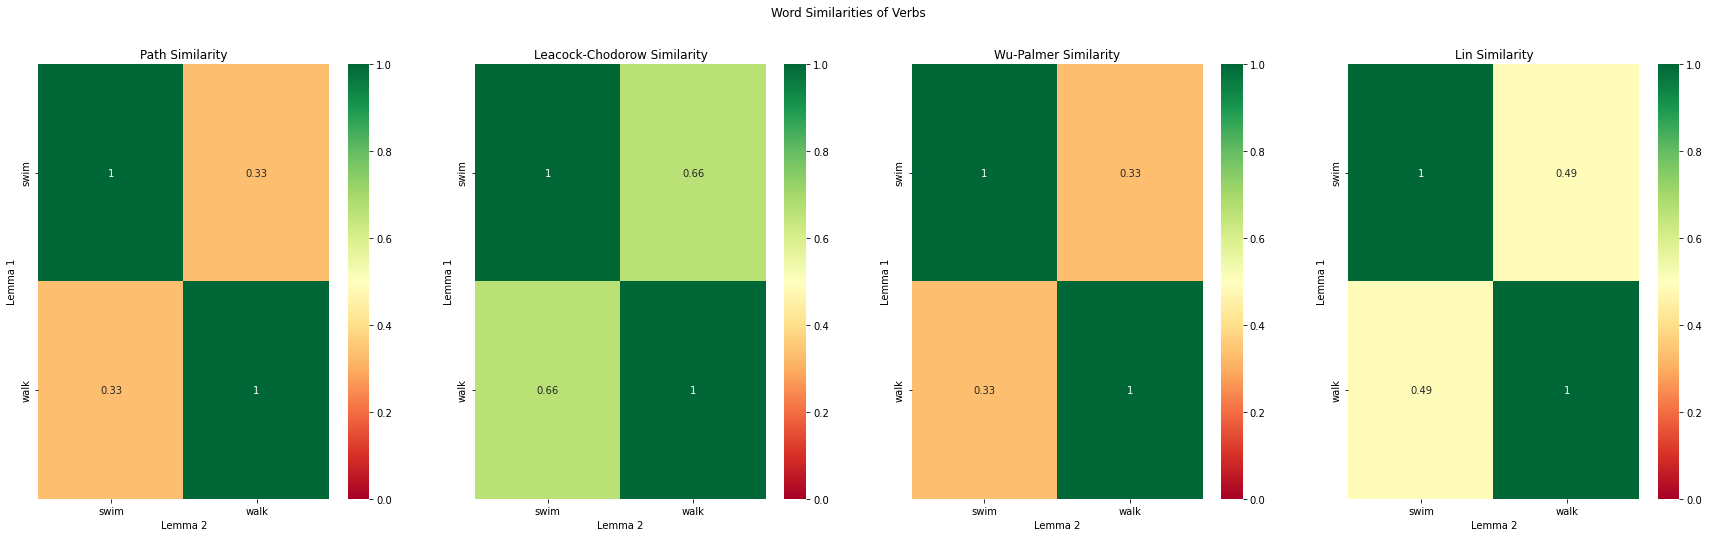

In [ ]:
# for the heatmap we want all combinations
data_sim = []
data_sim_vb = []

for syn1, syn2 in itertools.product(synsets, synsets):
  if syn1[0][1] == syn2[0][1]:
    pat = syn1[1][0].path_similarity(syn2[1][0])
    lch = syn1[1][0].lch_similarity(syn2[1][0]) / syn1[1][0].lch_similarity(syn1[1][0]) 
    wup = syn1[1][0].wup_similarity(syn2[1][0]) 
    lin = syn1[1][0].lin_similarity(syn2[1][0], brown_ic)
    if syn1[0][1] == 'NN':
      data_sim.append([syn1[0][0], syn2[0][0], pat, lch, wup, lin])
    else:
      data_sim_vb.append([syn1[0][0], syn2[0][0], pat, lch, wup, lin])

df = pd.DataFrame(data_sim, columns = ['Lemma 1', 'Lemma 2', 'Path', 'LC', 'WP', 'Lin'])
pa = df.pivot('Lemma 1', 'Lemma 2', 'Path')
lc = df.pivot('Lemma 1', 'Lemma 2', 'LC')
wp = df.pivot('Lemma 1', 'Lemma 2', 'WP')
li = df.pivot('Lemma 1', 'Lemma 2', 'Lin')


fig, ax = plt.subplots(1, 4, figsize = (30, 8))
_ = fig.suptitle('Word Similarities of Nouns')
_ = sns.heatmap(pa, ax = ax[0], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Path Similarity')
_ = sns.heatmap(lc, ax = ax[1], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Leacock-Chodorow Similarity')
_ = sns.heatmap(wp, ax = ax[2], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Wu-Palmer Similarity')
_ = sns.heatmap(li, ax = ax[3], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Lin Similarity')

df = pd.DataFrame(data_sim_vb, columns = ['Lemma 1', 'Lemma 2', 'Path', 'LC', 'WP', 'Lin'])
pa = df.pivot('Lemma 1', 'Lemma 2', 'Path')
lc = df.pivot('Lemma 1', 'Lemma 2', 'LC')
wp = df.pivot('Lemma 1', 'Lemma 2', 'WP')
li = df.pivot('Lemma 1', 'Lemma 2', 'Lin')

fig, ax = plt.subplots(1, 4, figsize = (30, 8))
_ = fig.suptitle('Word Similarities of Verbs')
_ = sns.heatmap(pa, ax = ax[0], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Path Similarity')
_ = sns.heatmap(lc, ax = ax[1], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Leacock-Chodorow Similarity')
_ = sns.heatmap(wp, ax = ax[2], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Wu-Palmer Similarity')
_ = sns.heatmap(li, ax = ax[3], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Lin Similarity')

In [ ]:
# just read the output
x = wn.synsets('girl', wn.NOUN)[0]
y = wn.synsets('woman', wn.NOUN)[0]

print('LCS of synset with itself with True min depth')
print('\tgirl.lcs(woman) =', x.lowest_common_hypernyms(x, use_min_depth=True))
print('\twoman.lcs(girl) =', y.lowest_common_hypernyms(y, use_min_depth=True))
print('\nLCS of synset with itself with False min depth')
print('\tgirl.lcs(woman) =', x.lowest_common_hypernyms(y, use_min_depth=False))
print('\twoman.lcs(girl) =', y.lowest_common_hypernyms(x, use_min_depth=False))
print('-'*80)

print('Lets check with the different synsets what the LCS gives us')
print('LCS with True min depth:')
print('\tgirl.lcs(woman) =', x.lowest_common_hypernyms(y, use_min_depth=True))
print('\twoman.lcs(girl) =', y.lowest_common_hypernyms(x, use_min_depth=True))

print('\nSo, Wu-Palmer would return LCS organism both times since it appears first in both calculations')
print('Taking LCS as organism then, computing the Wu-Palmer Sim manually we get')
lcs = wn.synsets('organism', wn.NOUN)[0]

# manually computing the wup-sim
depth = lcs.max_depth() + 1
len1 = x.shortest_path_distance(lcs, simulate_root=True) + depth
len2 = y.shortest_path_distance(lcs, simulate_root=True) + depth
print('WUP =', (2.0 * depth) / (len1 + len2))

print('\nThis is what girl-woman originally gave us, however, when checking woman-girl, we get a different result')
print('As we have seen in the LCS, it should be the same tho, since the first LCS returned is organism')
print('However, this is due that NLTK checks if the self synset (self.lcs(other)) is in the list of returned subsumers')
print('since "woman" is in the list of returned subsumers, it will calculate the Wu-Palrmer using woman as the LCS instead of organism')

print('\nTaking LCS as woman then, computing the Wu-Palmer Sim manually we get')
lcs = wn.synsets('woman', wn.NOUN)[0]

# manually computing the wup-sim
depth = lcs.max_depth() + 1
len1 = x.shortest_path_distance(lcs, simulate_root=True) + depth
len2 = y.shortest_path_distance(lcs, simulate_root=True) + depth
print('WUP =', (2.0 * depth) / (len1 + len2))

print('\nThis could probably be avoided by changing the use_min_depth field to False')
print('LCS with False min depth:')
print('\tgirl.lcs(woman) =', x.lowest_common_hypernyms(y, use_min_depth=False))
print('\twoman.lcs(girl) =', y.lowest_common_hypernyms(x, use_min_depth=False))
print('Which would result in having the previous WUP result for both combinations')

LCS of synset with itself with True min depth
	girl.lcs(woman) = [Synset('girl.n.01')]
	woman.lcs(girl) = [Synset('organism.n.01'), Synset('woman.n.01')]

LCS of synset with itself with False min depth
	girl.lcs(woman) = [Synset('woman.n.01')]
	woman.lcs(girl) = [Synset('woman.n.01')]
--------------------------------------------------------------------------------
Lets check with the different synsets what the LCS gives us
LCS with True min depth:
	girl.lcs(woman) = [Synset('organism.n.01'), Synset('woman.n.01')]
	woman.lcs(girl) = [Synset('organism.n.01'), Synset('woman.n.01')]

So, Wu-Palmer would return LCS organism both times since it appears first in both calculations
Taking LCS as organism then, computing the Wu-Palmer Sim manually we get
WUP = 0.631578947368421

This is what girl-woman originally gave us, however, when checking woman-girl, we get a different result
As we have seen in the LCS, it should be the same tho, since the first LCS returned is organism
However, this is du

# Conclusions

Foremost, an interesting thing appears when checking the Wu-Palmer Similarity, we see that the pair of words woman-girl, are not returning the same value when computing the two possible combinations. When measuring the similarity of synset `woman` with Synset `girl` we get a similarity of 0.95, while the other way around we get 0.63.

This is a bit weird since Wu-Palmer returns a score denoting how similar two word senses are, based on the depth of the two senses in the taxonomy and that of their LCS. It is based on path length, respective of the number of nodes along the shortest path between them, hence it should be symmetric. The details of why this is happening can be found in the previous output result, with its corresponding explanation and a possible workaround.

**What similarity seems better?**

We eliminate Path Similarity, since it only takes into account the length of the shortest path. This gives us values that are going to be always maximum 0.5 when not compared with itself. This results in having values that seem pretty small to us, even when the words are very close. For example, woman-girl is only at path length 1, which gives us a similarity of 0.5. Which, granted, are not the same word, however we feel we can do better.

We eliminate Wu-Palmer due to the LCS problems explained in the last result. We could compute it manually, taking into consideration the correct LCS however, it is difficult to say which similarity is more correct. For these reasons, we would just rather not deal with it until NLTK addresses it.

From Leacock-Chodrow vs. Lin, both seem fine. Leacock still uses path distance and the depth of the wordnet, while Lin is a bit more complex and uses the information content (IC) of the word taken from the frequencies in a corpus. Hence, if we have a specific corpus, we should probably prefer Lin to Leacock, since it will be more specific for our use case and be able to achieve more effective similarity comparisons.

On this specific example, we can see that Lin considers pretty different boy with woman and girl. Other than that, they are pretty similar. We can also see that it considers swim and walk more different than what Leacock considers them. 

